# Registration of video frames using optimal transport (MP-based approach)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import h5py
from scipy.ndimage import affine_transform
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from skimage.transform import downscale_local_mean

import imagerep
from utils import plot_maxproj, pixel_dist_3d

### Synthetic data

#### Parameters

In [3]:
# Random seed 
np.random.seed(1993)

# Image size
img_shape = (50, 25, 5)

#### Create synthetic data

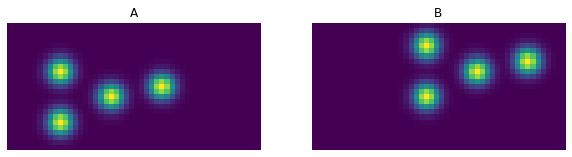

In [4]:
# Ground-truth transformation
beta = np.eye(3, 3)
alpha = np.array([12, 5, 0])

# Covariance used for all components
cov = 3 * np.eye(3)

# Locations of components in image A
x_a = np.array([
    [20, 10, 2],
    [10, 15, 3],
    [10, 5, 4],
    [30, 12, 3],
])

# Locations of components in image B
x_b = (x_a @ beta + alpha).astype(int)

# Array containing both locations
x = np.concatenate((x_a, x_b), axis=0)

# Weights for A and B
a = np.array([1, 1, 1, 1, 0, 0, 0, 0])
b = np.array([0, 0, 0, 0, 1, 1, 1, 1])

# Reconstruct A and B as images
a_img = imagerep.reconstruct_image(x, [cov], a, img_shape)
b_img = imagerep.reconstruct_image(x, [cov], b, img_shape)

plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(a_img)
plt.axis('off')
plt.title('A')

plt.subplot(122)
plot_maxproj(b_img)
plt.axis('off')
plt.title('B');

#### Compute optimal transport plan between frames

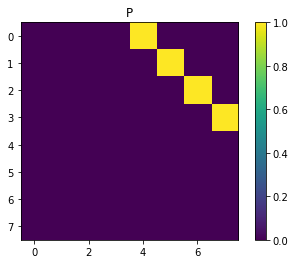

In [5]:
# Normalized distance matrix 
M_nn = ot.dist(x, metric='sqeuclidean')
M = M_nn / np.median(M_nn)

# Compute transport plan
P = ot.emd(a, b, M)

plt.imshow(P)
plt.colorbar()
plt.title('P');

#### Minimize cost function to estimate $\alpha$ and $\beta$

In [6]:
# Get pairs of points with values above threshold, and corresponding weights from P matrix
a_idx, b_idx = np.nonzero(P)
pts_a = x[a_idx]
pts_b = x[b_idx]
weights = P[a_idx, b_idx]

# Use sklearn.linear_model.LinearRegression to minimize cost function
model = LinearRegression(fit_intercept=True)
model.fit(pts_a, pts_b, sample_weight=weights)

# Estimates of transform parameters
alpha_est = model.intercept_
beta_est = model.coef_

print('alpha (est):')
print(alpha_est)
print('alpha (true):')
print(alpha)

print('beta (est):')
print(beta_est)
print('beta (true):')
print(beta)

alpha (est):
[1.20000000e+01 5.00000000e+00 2.66453526e-15]
alpha (true):
[12  5  0]
beta (est):
[[ 1.00000000e+00  2.50196237e-16  2.21182797e-15]
 [ 1.33897935e-17  1.00000000e+00 -1.55251030e-16]
 [-6.69489674e-18 -1.49295518e-16  1.00000000e+00]]
beta (true):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


#### Use estimated transform $T_{\alpha^*, \beta^*}$ to reconstruct $B$ from $A$

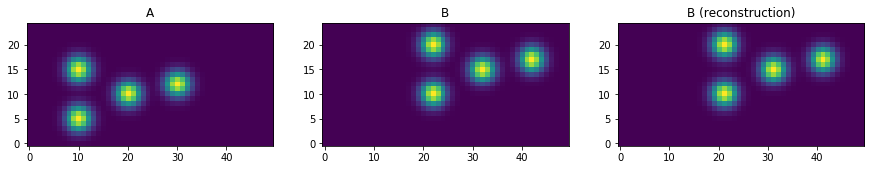

In [7]:
# Reconstruct B from A
x_b_recon = (x_a @ beta_est + alpha_est).astype(int)
b_recon_img = imagerep.reconstruct_image(x_b_recon, [cov], [1/3]*4, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(a_img)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(b_img)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(b_recon_img)
plt.title('B (reconstruction)');

### Real data (single frame with known transformation)

#### Load frames and MP components from file

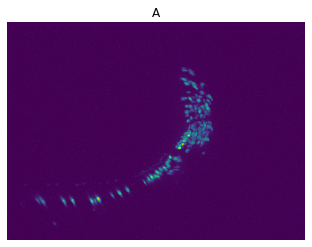

In [8]:
data_path = '/home/mn2822/Desktop/WormOT/data/zimmer/sample/frame_mp_0500_0502.h5'
n_iter = 50

with h5py.File(data_path) as f:
    
    # Load global MP parameters
    max_iter = f['n_iter'][...]
    cov = f['cov'][...]
    
    # Load frame and MPs
    a_full_img = f['frame_1/img'][...]
    pts_a = f['frame_1/pts'][0:n_iter, :]
    wts_a = f['frame_1/wts'][0:n_iter].flatten()
    
img_shape = a_full_img.shape
  
plot_maxproj(a_full_img)
plt.title('A')
plt.axis('off');

#### Reconstruct images in MP coordinate system

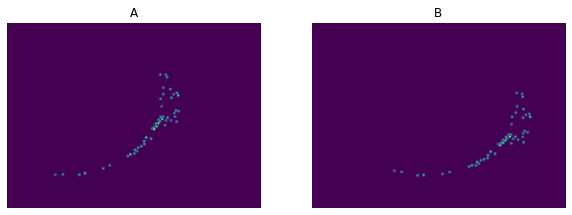

In [9]:
# Ground-truth transformation (rotation + translation)
theta = np.pi / 16
beta = np.array([
    [np.cos(theta), -np.sin(theta), 0], 
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])
alpha = np.array([100, 50, 0])

# Create MPs for B by applying transformation to A (weights are same)
pts_b = (pts_a @ beta + alpha).astype(int)
wts_b = wts_a

# Matrix containing locations of both sets of MPs
x = np.concatenate((pts_a, pts_b), axis=0)

# Put weights in common coordinate system and normalize them
a_nn = np.concatenate((wts_a, np.zeros(n_iter)), axis=0)
b_nn = np.concatenate((np.zeros(n_iter), wts_b), axis=0)
a = a_nn / np.sum(a_nn)
b = b_nn / np.sum(b_nn)

# Reconstruct A and B as images
a_img = imagerep.reconstruct_image(x, [cov], a, img_shape)
b_img = imagerep.reconstruct_image(x, [cov], b, img_shape)

plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(a_img)
plt.axis('off')
plt.title('A')

plt.subplot(122)
plot_maxproj(b_img)
plt.axis('off')
plt.title('B');

#### Compute optimal transport plan between frames

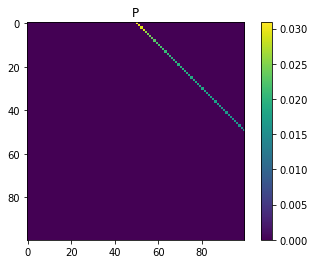

In [10]:
# Normalized distance matrix 
M_nn = ot.dist(x, metric='sqeuclidean')
M = M_nn / np.median(M_nn)

# Compute transport plan
P = ot.emd(a, b, M)

plt.imshow(P)
plt.colorbar()
plt.title('P');

#### Minimize cost function to estimate $\alpha$ and $\beta$

In [11]:
# Get pairs of points with values above threshold, and corresponding weights from P matrix
a_idx, b_idx = np.nonzero(P)
pts_a = x[a_idx]
pts_b = x[b_idx]
weights = P[a_idx, b_idx]

# Use sklearn.linear_model.LinearRegression to minimize cost function
model = LinearRegression(fit_intercept=True)
model.fit(pts_a, pts_b, sample_weight=weights)

# Estimates of transform parameters
alpha_est = model.intercept_
beta_est = model.coef_

print('alpha (est):')
print(alpha_est)
print('beta (est):')
print(beta_est)

alpha (est):
[ 9.99253345e+01  4.94729130e+01 -1.24344979e-14]
beta (est):
[[ 9.79683324e-01  1.95578005e-01 -3.37655006e-03]
 [-1.94163589e-01  9.79922989e-01 -1.42306270e-02]
 [ 2.05891210e-17 -1.07331229e-17  1.00000000e+00]]


#### Use estimated transform $T_{\alpha^*, \beta^*}$ to reconstruct $B$ from $A$

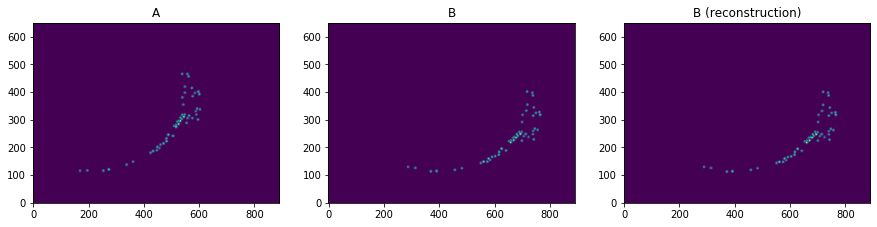

In [12]:
# Points and weights for A
pts = x[0:n_iter]
wts = a[0:n_iter]

x_b_recon = (pts @ beta_est.T + alpha_est).astype(int)

# Only plot points that fall inside image
plot_idx = np.all((x_b_recon >= 0) & (x_b_recon < img_shape), axis=1)
x_b_recon_plot = x_b_recon[plot_idx]
wts_plot = wts[plot_idx]

b_recon_img = imagerep.reconstruct_image(x_b_recon_plot, [cov], wts_plot, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(a_img)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(b_img)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(b_recon_img)
plt.title('B (reconstruction)');

### Real data (two frames)

#### Load frames and MP components from file

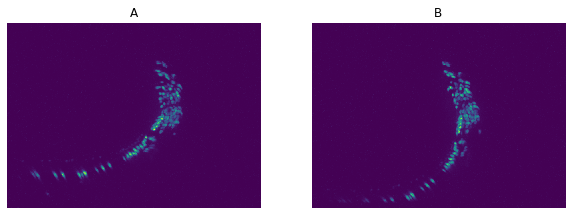

In [13]:
data_path = '/home/mn2822/Desktop/WormOT/data/zimmer/sample/frame_mp_0500_0502.h5'
n_iter = 50

with h5py.File(data_path) as f:
    
    # Load global MP parameters
    max_iter = f['n_iter'][...]
    cov = f['cov'][...]
    
    # Load first frame (and MPs)
    a_full_img = f['frame_1/img'][...]
    pts_a = f['frame_1/pts'][0:n_iter, :]
    wts_a = f['frame_1/wts'][0:n_iter].flatten()
    
    # Load second frame (and MPs)
    b_full_img = f['frame_2/img'][...]
    pts_b = f['frame_2/pts'][0:n_iter, :]
    wts_b = f['frame_2/wts'][0:n_iter].flatten()
    
img_shape = a_full_img.shape
  
plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(a_full_img)
plt.title('A')
plt.axis('off')

plt.subplot(122)
plot_maxproj(b_full_img)
plt.title('B')
plt.axis('off');

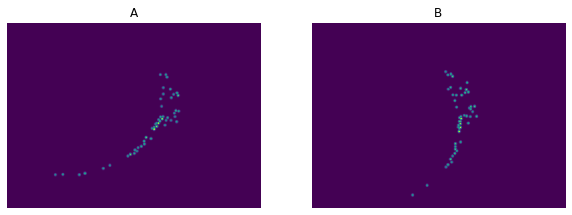

In [14]:
# Matrix containing locations of both sets of MPs
x = np.concatenate((pts_a, pts_b), axis=0)

# Put weights in common coordinate system and normalize them
a_nn = np.concatenate((wts_a, np.zeros(n_iter)), axis=0)
b_nn = np.concatenate((np.zeros(n_iter), wts_b), axis=0)
a = a_nn / np.sum(a_nn)
b = b_nn / np.sum(b_nn)

# Reconstruct A and B as images
a_img = imagerep.reconstruct_image(x, [cov], a, img_shape)
b_img = imagerep.reconstruct_image(x, [cov], b, img_shape)

plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(a_img)
plt.axis('off')
plt.title('A')

plt.subplot(122)
plot_maxproj(b_img)
plt.axis('off')
plt.title('B');

#### Compute optimal transport plan between frames

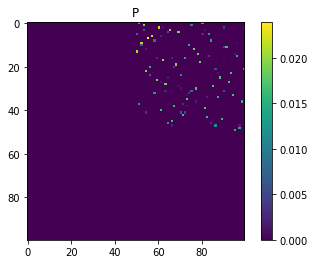

In [15]:
# Normalized distance matrix 
M_nn = ot.dist(x, metric='sqeuclidean')
M = M_nn / np.median(M_nn)

# Compute transport plan
P = ot.emd(a, b, M)

plt.imshow(P)
plt.colorbar()
plt.title('P');

#### Minimize cost function to estimate $\alpha$ and $\beta$

In [16]:
# Get pairs of points with values above threshold, and corresponding weights from P matrix
a_idx, b_idx = np.nonzero(P)
pts_a = x[a_idx]
pts_b = x[b_idx]
weights = P[a_idx, b_idx]

# Use sklearn.linear_model.LinearRegression to minimize cost function
model = LinearRegression(fit_intercept=True)
model.fit(pts_a, pts_b, sample_weight=weights)

# Estimates of transform parameters
alpha_est = model.intercept_
beta_est = model.coef_

print('alpha (est):')
print(alpha_est)
print('beta (est):')
print(beta_est)

alpha (est):
[350.70619172 -82.3635308    7.4576774 ]
beta (est):
[[ 5.39659280e-01 -3.42298337e-01 -9.28036336e-01]
 [ 2.44327316e-01  8.77841748e-01  1.63276196e+00]
 [-5.26048794e-03 -2.36781502e-04  5.72745507e-01]]


#### Use estimated transform $T_{\alpha^*, \beta^*}$ to reconstruct $B$ from $A$

##### MP space

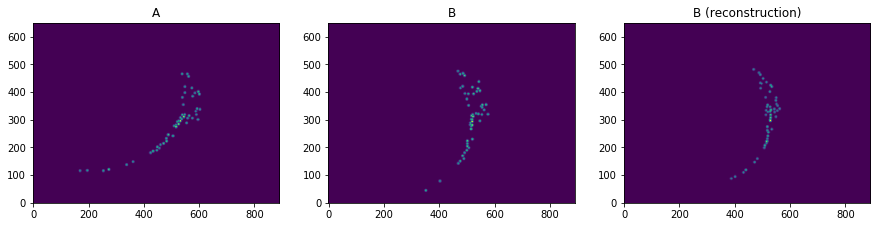

In [17]:
# Points and weights for A
pts = x[0:n_iter]
wts = a[0:n_iter]

x_b_recon = (pts @ beta_est.T + alpha_est).astype(int)

# Only plot points that fall inside image
plot_idx = np.all((x_b_recon >= 0) & (x_b_recon < img_shape), axis=1)
x_b_recon_plot = x_b_recon[plot_idx]
wts_plot = wts[plot_idx]

b_recon_img = imagerep.reconstruct_image(x_b_recon_plot, [cov], wts_plot, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(a_img)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(b_img)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(b_recon_img)
plt.title('B (reconstruction)');

##### Image space

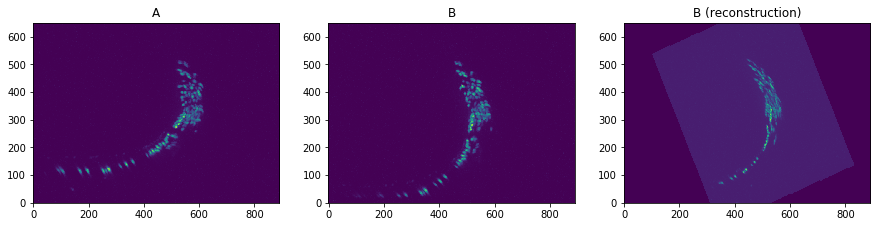

In [18]:
# Reconstruct A from B
inv_beta_est = np.linalg.inv(beta_est)
inv_alpha_est = -inv_beta_est @ alpha_est
b_full_img_recon = affine_transform(a_full_img, inv_beta_est, inv_alpha_est)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(a_full_img)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(b_full_img)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(b_full_img_recon)
plt.title('B (reconstruction)');